In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install timm torchinfo scikit-learn seaborn --quiet

## Import & Setup Device + Seed

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import timm
import time
import platform
import psutil
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# tampilkan grafik inline
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

Device: cuda


## Info Hardware

In [4]:
def get_hardware_info():
    info = {}

    # CPU
    info["cpu_name"] = platform.processor()
    info["cpu_cores"] = psutil.cpu_count(logical=False)
    info["cpu_threads"] = psutil.cpu_count(logical=True)

    # RAM
    info["ram_gb"] = round(psutil.virtual_memory().total / (1024**3), 2)

    # GPU
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_capability = torch.cuda.get_device_capability(0)
        info["gpu_name"] = gpu_name
        info["gpu_compute_capability"] = f"{gpu_capability[0]}.{gpu_capability[1]}"
    else:
        info["gpu_name"] = "None"
        info["gpu_compute_capability"] = None

    return info

hardware_info = get_hardware_info()
hardware_info

{'cpu_name': 'x86_64',
 'cpu_cores': 1,
 'cpu_threads': 2,
 'ram_gb': 12.67,
 'gpu_name': 'Tesla T4',
 'gpu_compute_capability': '7.5'}

## Path Dataset & Kelas

In [5]:
# SESUAIKAN path ini dengan lokasi dataset kamu
DATA_DIR = "/content/drive/MyDrive/IF25-4041-dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")

print("Train dir :", TRAIN_DIR)
print("Train csv :", TRAIN_CSV)

# Kelas Indonesian Food 5 class
CLASS_NAMES = ["nasi_goreng", "rendang", "soto_ayam", "bakso", "gado_gado"]
NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)

Train dir : /content/drive/MyDrive/IF25-4041-dataset/train
Train csv : /content/drive/MyDrive/IF25-4041-dataset/train.csv
Classes: ['nasi_goreng', 'rendang', 'soto_ayam', 'bakso', 'gado_gado']


## EDA & Distribusi Dataset

In [6]:
df = pd.read_csv(TRAIN_CSV)
df.head()

,filename,label
0,0001.jpg,gado_gado
1,0002.jpg,gado_gado
2,0003.jpg,rendang
3,0004.jpg,bakso
4,0005.jpg,bakso


In [7]:
class_counts = df['label'].value_counts().sort_index()
class_percent = class_counts / class_counts.sum() * 100

dist_df = pd.DataFrame({
    "class": class_counts.index,
    "count": class_counts.values,
    "percent": class_percent.values
})
dist_df

,class,count,percent
0,bakso,220,19.855596
1,gado_gado,215,19.404332
2,nasi_goreng,234,21.119134
3,rendang,227,20.487365
4,soto_ayam,212,19.133574


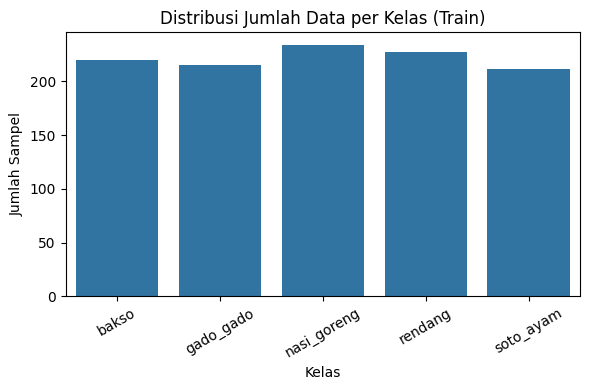

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(x=dist_df["class"], y=dist_df["count"])
plt.title("Distribusi Jumlah Data per Kelas (Train)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Split Train / Val / Test (70/15/15)

In [9]:
# 70% train, 30% temp (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

# 15% val, 15% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print("Total data :", len(df))
print("Train      :", len(train_df))
print("Val        :", len(val_df))
print("Test       :", len(test_df))

Total data : 1108
Train      : 775
Val        : 166
Test       : 167


In [10]:
def show_class_distribution(name, df_subset):
    counts = df_subset['label'].value_counts().sort_index()
    percent = counts / counts.sum() * 100
    display(pd.DataFrame({
        "subset": name,
        "class": counts.index,
        "count": counts.values,
        "percent": percent.values
    }))

show_class_distribution("train", train_df); print()
show_class_distribution("val",   val_df); print()
show_class_distribution("test",  test_df)

,subset,class,count,percent
0,train,bakso,154,19.870968
1,train,gado_gado,150,19.354839
2,train,nasi_goreng,164,21.161290
3,train,rendang,159,20.516129
4,train,soto_ayam,148,19.096774


,subset,class,count,percent
0,val,bakso,33,19.879518
1,val,gado_gado,32,19.277108
2,val,nasi_goreng,35,21.084337
3,val,rendang,34,20.481928
4,val,soto_ayam,32,19.277108


,subset,class,count,percent
0,test,bakso,33,19.760479
1,test,gado_gado,33,19.760479
2,test,nasi_goreng,35,20.958084
3,test,rendang,34,20.359281
4,test,soto_ayam,32,19.161677


## Transform


In [11]:
# Transform untuk training (augmentasi + normalisasi ImageNet)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # mean ImageNet
        std=[0.229, 0.224, 0.225]     # std ImageNet
    ),
])

# Transform untuk validation dan test (NO augmentasi, hanya resize + normalize)
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [12]:
label2idx = {c: i for i, c in enumerate(CLASS_NAMES)}
idx2label = {i: c for c, i in label2idx.items()}

class FoodDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, has_label=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.has_label = has_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['filename']
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        if self.has_label:
            label_str = row['label']
            label = label2idx[label_str]
            return image, label
        else:
            return image, fname

## Hyperparameter

In [13]:
# Hyperparameter global
BATCH_SIZE    = 16
NUM_EPOCHS    = 10
LR            = 1e-4
WEIGHT_DECAY  = 1e-4
NUM_WORKERS   = 2
NUM_CLASSES   = len(CLASS_NAMES)

# Model timm yang akan dibandingkan
MODEL_CONFIGS = {
    "vit_base_patch16_224":  "ViT-B16",
    "deit_small_patch16_224": "DeiT-Small",
    "swin_tiny_patch4_window7_224": "Swin-Tiny"
}

print("Models:", MODEL_CONFIGS)
print("Num epochs:", NUM_EPOCHS, "| LR:", LR, "| Weight decay:", WEIGHT_DECAY)

Models: {'vit_base_patch16_224': 'ViT-B16', 'deit_small_patch16_224': 'DeiT-Small', 'swin_tiny_patch4_window7_224': 'Swin-Tiny'}
Num epochs: 10 | LR: 0.0001 | Weight decay: 0.0001


## Dataset & DataLoader

In [14]:
# Dataset & DataLoader
IMG_DIR = TRAIN_DIR

train_dataset = FoodDataset(train_df, IMG_DIR, transform=train_transform,    has_label=True)
val_dataset   = FoodDataset(val_df,   IMG_DIR, transform=val_test_transform, has_label=True)
test_dataset  = FoodDataset(test_df,  IMG_DIR, transform=val_test_transform, has_label=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

len(train_dataset), len(val_dataset), len(test_dataset)

(775, 166, 167)

## Model Factory & Parameter Count

In [15]:
def create_model(model_name, num_classes=NUM_CLASSES, pretrained=True):
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model.to(device)


def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    size_mb = total_params * 4 / (1024**2)  # float32 4 byte
    return total_params, trainable_params, non_trainable_params, size_mb

## Training & Evaluasi per Epoch

In [16]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

def train_one_epoch(model, optimizer, criterion, dataloader):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


def evaluate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

## Metrik Performa

In [17]:
def compute_metrics(y_true, y_pred, model_pretty_name):
    """
    Menghitung:
    - accuracy keseluruhan
    - precision/recall/F1 per kelas
    - macro average
    - weighted average
    """
    acc = accuracy_score(y_true, y_pred)

    prec_cls, rec_cls, f1_cls, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=list(range(NUM_CLASSES)),
        zero_division=0
    )

    macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    wt_prec, wt_rec, wt_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    rows = []

    # per kelas
    for i, cls_name in enumerate(CLASS_NAMES):
        rows.append({
            "model": model_pretty_name,
            "type": "per_class",
            "class": cls_name,
            "precision": prec_cls[i],
            "recall": rec_cls[i],
            "f1": f1_cls[i],
            "support": int(support[i]),
            "accuracy_overall": acc
        })

    # macro average
    rows.append({
        "model": model_pretty_name,
        "type": "macro_avg",
        "class": "macro_avg",
        "precision": macro_prec,
        "recall": macro_rec,
        "f1": macro_f1,
        "support": int(sum(support)),
        "accuracy_overall": acc
    })

    # weighted average
    rows.append({
        "model": model_pretty_name,
        "type": "weighted_avg",
        "class": "weighted_avg",
        "precision": wt_prec,
        "recall": wt_rec,
        "f1": wt_f1,
        "support": int(sum(support)),
        "accuracy_overall": acc
    })

    metrics_df = pd.DataFrame(rows)
    return acc, metrics_df

In [18]:
def plot_learning_curve(history_df, model_pretty_name):
    os.makedirs(f"results/{model_pretty_name}", exist_ok=True)

    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    ax[0].plot(history_df["epoch"], history_df["train_loss"], label="Train Loss")
    ax[0].plot(history_df["epoch"], history_df["val_loss"], label="Val Loss")
    ax[0].set_title(f"{model_pretty_name} Loss")
    ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(history_df["epoch"], history_df["train_acc"], label="Train Acc")
    ax[1].plot(history_df["epoch"], history_df["val_acc"], label="Val Acc")
    ax[1].set_title(f"{model_pretty_name} Accuracy")
    ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    plt.tight_layout()
    out_path = f"results/{model_pretty_name}/learning_curve.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Saved learning curve to {out_path}")

In [19]:
def plot_confusion_matrix(y_true, y_pred, model_pretty_name):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_pretty_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    out_path = f"results/{model_pretty_name}/confusion_matrix.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Saved confusion matrix to {out_path}")

## Fungsi Waktu Inferensi

In [20]:
def measure_inference_time(model, dataloader, num_warmup=3):
    """
    Mengukur waktu inferensi dengan:
    - warm-up beberapa batch awal (tidak dihitung)
    - timing seluruh test set (diasumsikan >= 100 gambar)
    - output:
        avg_ms_per_image : rata-rata waktu per gambar (ms)
        std_ms_per_image : standar deviasi waktu per gambar (ms)
        total_time_s     : total waktu untuk seluruh test set (detik)
        throughput_img_per_s : gambar per detik
    """
    model.eval()
    batch_times = []
    total_images = 0

    # ====== WARM-UP (tidak dihitung) ======
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            _ = model(images)
            if i >= num_warmup - 1:
                break

    # ====== PENGUKURAN SEBENARNYA ======
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            # sinkronisasi GPU sebelum mulai dan sesudah selesai (lebih akurat)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start = time.time()

            _ = model(images)

            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.time()

            batch_time = end - start
            batch_times.append(batch_time)
            total_images += images.size(0)

    # konversi ke waktu per gambar (ms) berdasarkan tiap batch
    times_per_image_ms = [
        (t / images_per_batch) * 1000.0
        for t, images_per_batch in zip(batch_times, [BATCH_SIZE] * len(batch_times))
    ]

    avg_ms = float(np.mean(times_per_image_ms))
    std_ms = float(np.std(times_per_image_ms))
    total_time = float(sum(batch_times))
    throughput = total_images / total_time if total_time > 0 else 0.0

    return {
        "avg_ms_per_image": avg_ms,
        "std_ms_per_image": std_ms,
        "total_time_s": total_time,
        "throughput_img_per_s": throughput,
        "n_images_measured": total_images
    }

## Training Model

In [21]:
def train_model(model_name, pretty_name,
                train_loader, val_loader,
                num_epochs=NUM_EPOCHS,
                lr=LR, weight_decay=WEIGHT_DECAY):

    print(f"\n===== Training {pretty_name} ({model_name}) =====")
    set_seed(42)  # supaya konsisten per model

    model = create_model(model_name)
    total_p, trainable_p, non_train_p, size_mb = count_parameters(model)
    print(f"Total params: {total_p:,} | Trainable: {trainable_p:,} | Non-trainable: {non_train_p:,} | Size ~ {size_mb:.2f} MB")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    best_val_acc = 0.0
    best_state_dict = None
    best_y_true = None
    best_y_pred = None

    for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader)
        val_loss, val_acc, y_true, y_pred = evaluate(model, criterion, val_loader)

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = model.state_dict().copy()
            best_y_true = y_true
            best_y_pred = y_pred

    # simpan best weight
    os.makedirs("weights", exist_ok=True)
    weight_path = f"weights/{pretty_name.replace('-', '').lower()}_best.pth"
    torch.save(best_state_dict, weight_path)
    print(f"Best {pretty_name} saved to {weight_path} with val_acc={best_val_acc:.4f}")

    # pakai best weight untuk evaluasi akhir
    model.load_state_dict(best_state_dict)

    history_df = pd.DataFrame(history)
    acc, metrics_df = compute_metrics(best_y_true, best_y_pred, pretty_name)

    os.makedirs(f"results/{pretty_name}", exist_ok=True)
    history_df.to_csv(f"results/{pretty_name}/history.csv", index=False)
    metrics_df.to_csv(f"results/{pretty_name}/metrics.csv", index=False)

    plot_learning_curve(history_df, pretty_name)
    plot_confusion_matrix(best_y_true, best_y_pred, pretty_name)

    return {
        "model": model,
        "weight_path": weight_path,
        "history": history_df,
        "metrics": metrics_df,
        "val_acc": best_val_acc,
        "params": {
            "total": total_p,
            "trainable": trainable_p,
            "non_trainable": non_train_p,
            "size_mb": size_mb
        }
    }

## Loop Training


===== Training ViT-B16 (vit_base_patch16_224) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total params: 85,802,501 | Trainable: 85,802,501 | Non-trainable: 0 | Size ~ 327.31 MB


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10] Train Loss: 0.7042 Acc: 0.7484 | Val Loss: 0.1532 Acc: 0.9578


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/10] Train Loss: 0.2571 Acc: 0.9174 | Val Loss: 0.2003 Acc: 0.9096


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/10] Train Loss: 0.2897 Acc: 0.9058 | Val Loss: 0.0960 Acc: 0.9578


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/10] Train Loss: 0.1805 Acc: 0.9355 | Val Loss: 0.0419 Acc: 0.9880


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/10] Train Loss: 0.2547 Acc: 0.9187 | Val Loss: 0.0441 Acc: 0.9880


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/10] Train Loss: 0.1848 Acc: 0.9432 | Val Loss: 0.0947 Acc: 0.9639


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/10] Train Loss: 0.2036 Acc: 0.9342 | Val Loss: 0.0530 Acc: 0.9880


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/10] Train Loss: 0.1919 Acc: 0.9329 | Val Loss: 0.1768 Acc: 0.9217


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/10] Train Loss: 0.1677 Acc: 0.9419 | Val Loss: 0.0395 Acc: 0.9819


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/10] Train Loss: 0.1435 Acc: 0.9587 | Val Loss: 0.0515 Acc: 0.9819
Best ViT-B16 saved to weights/vitb16_best.pth with val_acc=0.9880


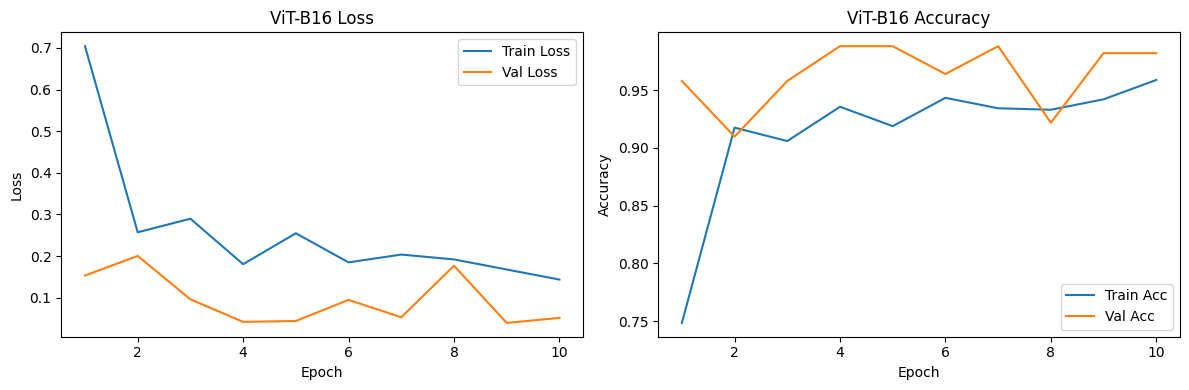

Saved learning curve to results/ViT-B16/learning_curve.png


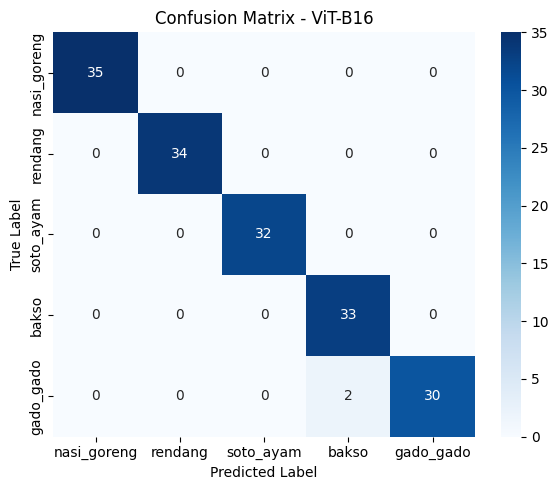

Saved confusion matrix to results/ViT-B16/confusion_matrix.png

===== Training DeiT-Small (deit_small_patch16_224) =====


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Total params: 21,667,589 | Trainable: 21,667,589 | Non-trainable: 0 | Size ~ 82.66 MB


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10] Train Loss: 0.5804 Acc: 0.8000 | Val Loss: 0.1391 Acc: 0.9639


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/10] Train Loss: 0.3528 Acc: 0.8645 | Val Loss: 0.0989 Acc: 0.9819


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/10] Train Loss: 0.1114 Acc: 0.9677 | Val Loss: 0.1007 Acc: 0.9639


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/10] Train Loss: 0.1269 Acc: 0.9535 | Val Loss: 0.0552 Acc: 0.9759


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/10] Train Loss: 0.1233 Acc: 0.9613 | Val Loss: 0.1021 Acc: 0.9639


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/10] Train Loss: 0.1345 Acc: 0.9548 | Val Loss: 0.1158 Acc: 0.9639


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/10] Train Loss: 0.1377 Acc: 0.9600 | Val Loss: 0.0701 Acc: 0.9699


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/10] Train Loss: 0.0735 Acc: 0.9755 | Val Loss: 0.0168 Acc: 1.0000


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/10] Train Loss: 0.1059 Acc: 0.9639 | Val Loss: 0.1236 Acc: 0.9639


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/10] Train Loss: 0.0945 Acc: 0.9690 | Val Loss: 0.0383 Acc: 0.9819
Best DeiT-Small saved to weights/deitsmall_best.pth with val_acc=1.0000


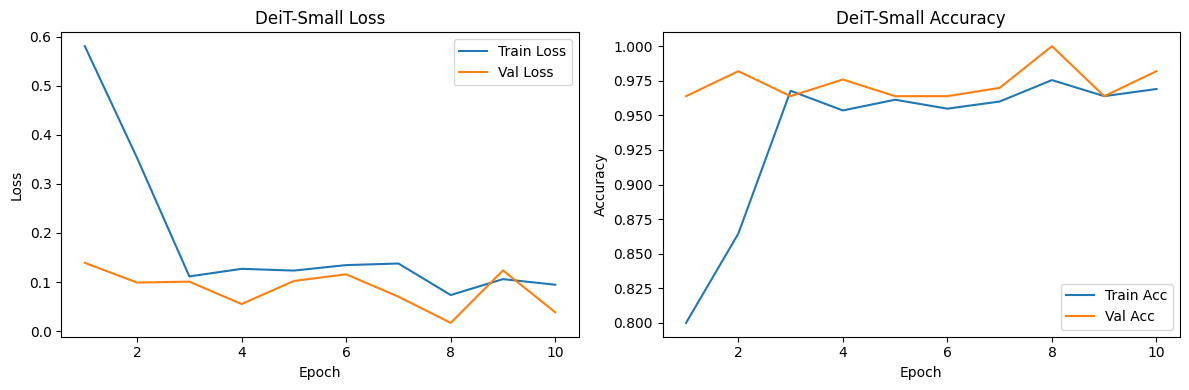

Saved learning curve to results/DeiT-Small/learning_curve.png


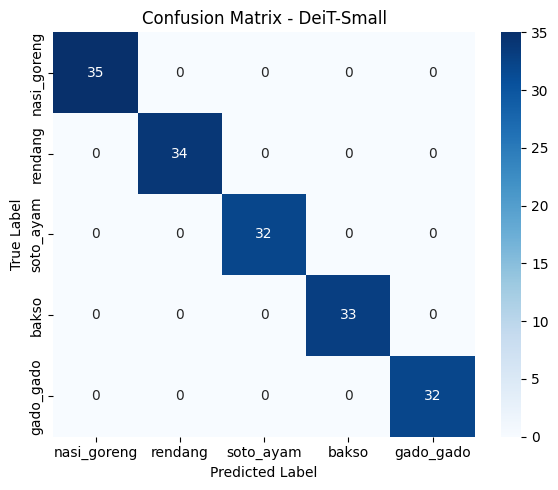

Saved confusion matrix to results/DeiT-Small/confusion_matrix.png

===== Training Swin-Tiny (swin_tiny_patch4_window7_224) =====


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Total params: 27,523,199 | Trainable: 27,523,199 | Non-trainable: 0 | Size ~ 104.99 MB


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10] Train Loss: 0.6619 Acc: 0.7458 | Val Loss: 0.0910 Acc: 0.9819


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/10] Train Loss: 0.2277 Acc: 0.9277 | Val Loss: 0.0251 Acc: 1.0000


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/10] Train Loss: 0.1705 Acc: 0.9523 | Val Loss: 0.0316 Acc: 0.9880


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/10] Train Loss: 0.1098 Acc: 0.9639 | Val Loss: 0.0150 Acc: 0.9940


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/10] Train Loss: 0.0952 Acc: 0.9665 | Val Loss: 0.0205 Acc: 0.9940


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/10] Train Loss: 0.1143 Acc: 0.9626 | Val Loss: 0.0227 Acc: 0.9940


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/10] Train Loss: 0.0889 Acc: 0.9729 | Val Loss: 0.0521 Acc: 0.9759


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/10] Train Loss: 0.1088 Acc: 0.9665 | Val Loss: 0.0393 Acc: 0.9880


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/10] Train Loss: 0.0954 Acc: 0.9716 | Val Loss: 0.0335 Acc: 0.9940


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/10] Train Loss: 0.1122 Acc: 0.9613 | Val Loss: 0.0263 Acc: 0.9819
Best Swin-Tiny saved to weights/swintiny_best.pth with val_acc=1.0000


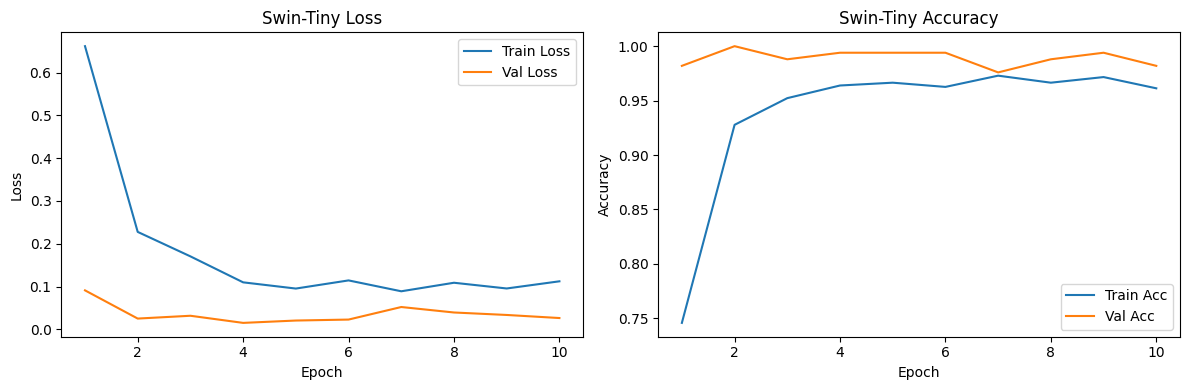

Saved learning curve to results/Swin-Tiny/learning_curve.png


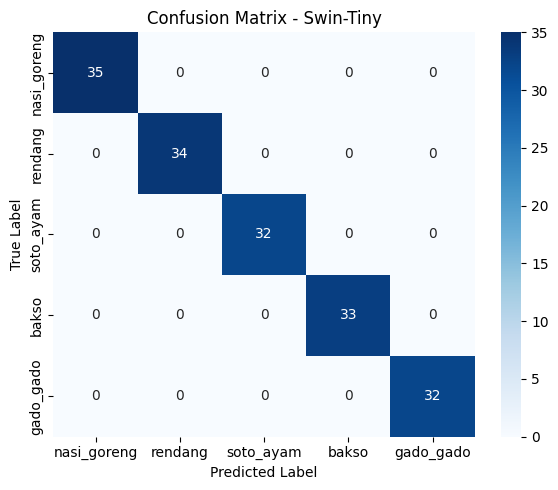

Saved confusion matrix to results/Swin-Tiny/confusion_matrix.png
=== PARAMETER SUMMARY ===


,model,total_params,trainable_params,non_trainable_params,size_mb
0,ViT-B16,85802501,85802501,0,327.310566
1,DeiT-Small,21667589,21667589,0,82.655293
2,Swin-Tiny,27523199,27523199,0,104.992672


=== METRICS SUMMARY (macro_avg) ===


,model,type,class,precision,recall,f1,support,accuracy_overall,val_acc
0,ViT-B16,macro_avg,macro_avg,0.988571,0.9875,0.987666,166,0.987952,0.987952
1,DeiT-Small,macro_avg,macro_avg,1.000000,1.0000,1.000000,166,1.000000,1.000000
2,Swin-Tiny,macro_avg,macro_avg,1.000000,1.0000,1.000000,166,1.000000,1.000000


In [22]:
all_results = {}
all_metrics_list = []
params_summary = []

for model_name, pretty_name in MODEL_CONFIGS.items():
    result = train_model(
        model_name=model_name,
        pretty_name=pretty_name,
        train_loader=train_loader,
        val_loader=val_loader
    )
    all_results[pretty_name] = result

    # simpan metrics macro_avg
    metrics_df = result["metrics"]
    macro_row = metrics_df[metrics_df["type"] == "macro_avg"].copy()
    macro_row["val_acc"] = result["val_acc"]
    all_metrics_list.append(macro_row)

    # simpan parameter summary
    p = result["params"]
    params_summary.append({
        "model": pretty_name,
        "total_params": p["total"],
        "trainable_params": p["trainable"],
        "non_trainable_params": p["non_trainable"],
        "size_mb": p["size_mb"]
    })

metrics_summary_df = pd.concat(all_metrics_list, ignore_index=True)
params_df = pd.DataFrame(params_summary)

print("=== PARAMETER SUMMARY ===")
display(params_df)

print("=== METRICS SUMMARY (macro_avg) ===")
display(metrics_summary_df)

## Waktu Inferensi di Test Set

In [23]:
test_inference_results = []

for model_name, pretty_name in MODEL_CONFIGS.items():
    print(f"\n[TEST INFERENCE] {pretty_name}")

    # load best weight
    model = create_model(model_name)
    weight_path = all_results[pretty_name]["weight_path"]
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)

    # ukur waktu inferensi di SELURUH test_loader
    inf = measure_inference_time(model, test_loader)

    test_inference_results.append({
        "model": pretty_name,
        # dari measure_inference_time (rata-rata & std)
        "avg_ms_per_image": inf["avg_ms_per_image"],
        "std_ms_per_image": inf["std_ms_per_image"],
        "total_time_s": inf["total_time_s"],
        "throughput_img_per_s": inf["throughput_img_per_s"],
        "n_images_measured": inf["n_images_measured"],
        # info hardware
        "gpu_name": hardware_info["gpu_name"],
        "cpu_name": hardware_info["cpu_name"],
        "cpu_cores": hardware_info["cpu_cores"],
        "cpu_threads": hardware_info["cpu_threads"],
        "ram_gb": hardware_info["ram_gb"],
    })

inference_test_df = pd.DataFrame(test_inference_results)

print("\n=== INFERENCE TIME ON TEST SET ===")
display(inference_test_df)

# Simpan ke file .csv untuk laporan / GitHub
inference_test_df.to_csv("inference_test_summary.csv", index=False)


[TEST INFERENCE] ViT-B16

[TEST INFERENCE] DeiT-Small

[TEST INFERENCE] Swin-Tiny

=== INFERENCE TIME ON TEST SET ===


,model,avg_ms_per_image,std_ms_per_image,total_time_s,throughput_img_per_s,n_images_measured,gpu_name,cpu_name,cpu_cores,cpu_threads,ram_gb
0,ViT-B16,10.582813,2.357347,1.862575,89.660816,167,Tesla T4,x86_64,1,2,12.67
1,DeiT-Small,3.134457,0.902570,0.551664,302.720303,167,Tesla T4,x86_64,1,2,12.67
2,Swin-Tiny,3.826992,0.671454,0.673551,247.939796,167,Tesla T4,x86_64,1,2,12.67


In [24]:
def predict_test_split_to_csv(model, model_pretty_name, df_split, img_dir, transform, out_dir="results"):
    model.eval()
    filenames = df_split['filename'].tolist()
    preds = []

    with torch.no_grad():
        for fname in filenames:
            img_path = os.path.join(img_dir, fname)
            img = Image.open(img_path).convert("RGB")
            x = transform(img).unsqueeze(0).to(device)
            outputs = model(x)
            _, pred_idx = torch.max(outputs, 1)
            preds.append(idx2label[pred_idx.item()])

    out_df = pd.DataFrame({"filename": filenames, "label": preds})
    os.makedirs(f"{out_dir}/{model_pretty_name}", exist_ok=True)
    out_path = f"{out_dir}/{model_pretty_name}/jawaban_{model_pretty_name.lower()}.csv"
    out_df.to_csv(out_path, index=False)
    print(f"Saved predictions to {out_path}")
    return out_df

In [25]:
for model_name, pretty_name in MODEL_CONFIGS.items():
    print(f"\nGenerating predictions for TEST SPLIT using {pretty_name}...")

    model = create_model(model_name)
    weight_path = all_results[pretty_name]["weight_path"]
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)

    _ = predict_test_split_to_csv(
        model,
        pretty_name,
        test_df,
        IMG_DIR,
        val_test_transform
    )


Generating predictions for TEST SPLIT using ViT-B16...
Saved predictions to results/ViT-B16/jawaban_vit-b16.csv

Generating predictions for TEST SPLIT using DeiT-Small...
Saved predictions to results/DeiT-Small/jawaban_deit-small.csv

Generating predictions for TEST SPLIT using Swin-Tiny...
Saved predictions to results/Swin-Tiny/jawaban_swin-tiny.csv
